Using device: cpu
L shape: torch.Size([10000, 10000]), L device: cpu


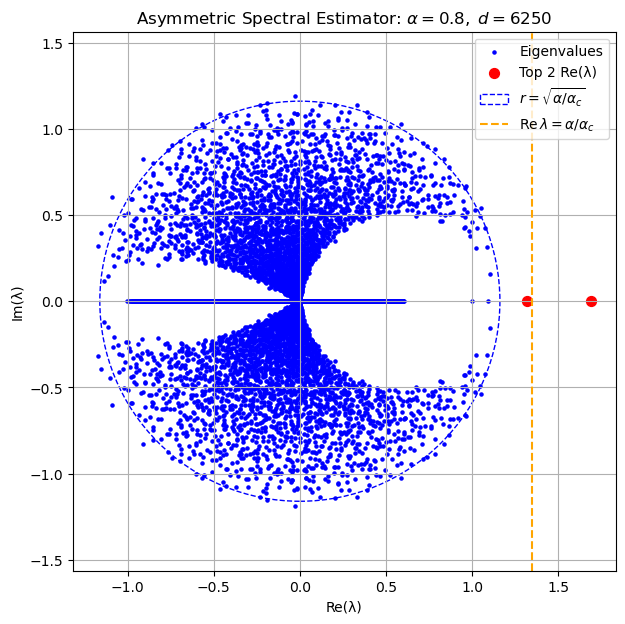

In [ ]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# Experiment parameters
n = 5000               # number of samples
p = 2                  # subspace dimension
alpha = 0.8
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Input matrix X ∈ ℝ^{n×d}
X = torch.randn(n, d, device=device) / np.sqrt(d)

# Ground-truth subspace W* and observations Z = XW*
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2  # link function y = z1 * z2

# Preprocessing G(y) ∈ ℝ^{n×p×p} (Bessel-based)
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1 = besselk(1, abs_y)
K0 = besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0  # numerical stability

# Build G(y): per-sample 2×2 symmetric block
G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Asymmetric spectral matrix L ∈ ℝ^{(np)×(np)}
XXT = X @ X.T                      # shape: (n, n)
XXT.fill_diagonal_(0.0)            # remove diagonal entries

# L blocks: (iμ, jν) entries
A = XXT[:, :, None, None]          # shape: (n, n, 1, 1)
G_broadcast = G_y[None, :, :, :]   # shape: (1, n, p, p)
L_blocks = A * G_broadcast         # shape: (n, n, p, p)
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)
print(f"L shape: {L.shape}, L device: {L.device}")

# Eigenvalues and spectrum
eigvals = torch.linalg.eigvals(L)
eigvals_np = eigvals.detach().cpu().numpy()
eigvals_real = eigvals_np.real

# Top-2 eigenvalues by real part
top2_idx = np.argsort(eigvals_real)[-2:]
top2_vals = eigvals_np[top2_idx]

# Spectrum visualization
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=5, color='blue', label='Eigenvalues')
plt.scatter(top2_vals.real, top2_vals.imag, color='red', s=50, label='Top 2 Re(λ)')

# Theoretical spectral radius and threshold
r = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c
circle = plt.Circle((0, 0), r, color='blue', fill=False, linestyle='--',
                    label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--',
            label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')

# Figure settings
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.title(rf'Asymmetric Spectral Estimator: $\alpha = {alpha},\ d = {d}$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


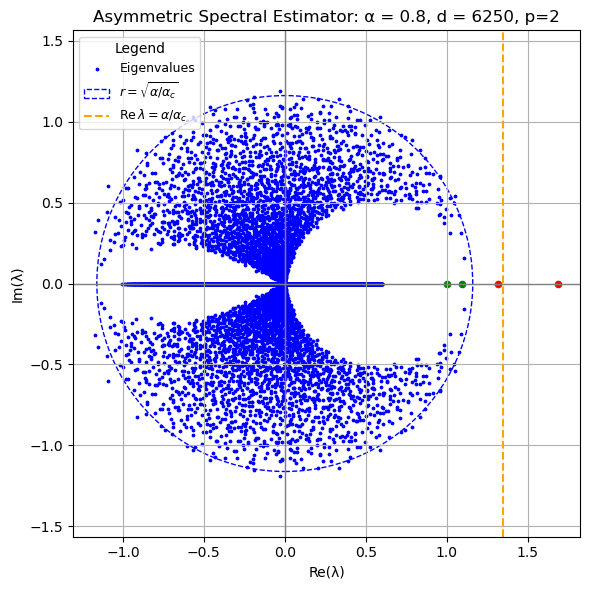

In [ ]:
# Thresholds
R = np.sqrt(alpha / alpha_c)        # spectral radius (blue dashed circle)
thresh_ext = alpha / alpha_c        # external threshold (orange dashed line)

# Keep real-valued eigenvalues
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
real_parts = eigvals_real_only.real

# Red: top-2 by Re(λ)
red_vals = eigvals_real_only[np.argsort(real_parts)[-2:]]

# Orange: R < Re(λ) < thresh_ext; also collect inner candidates for green
orange_vals = []
green_candidates = []
for val in eigvals_real_only:
    if R < val.real < thresh_ext:
        orange_vals.append(val)
    elif val.real < R:
        green_candidates.append(val)

# Green: top-2 internal real-axis points (largest Re inside circle)
green_vals = sorted(green_candidates, key=lambda z: -z.real)[:2]

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")

# Radius + vertical threshold
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False,
                    label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--",
            label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

# Red markers (R1, R2)
for i, val in enumerate(sorted(red_vals, key=lambda x: -x.real)):
    plt.scatter(val.real, val.imag, color="red", s=20)

# Green markers
for i, val in enumerate(sorted(green_vals, key=lambda x: -x.real)):
    plt.scatter(val.real, val.imag, color="green", s=20)

# Axes and labels
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p={p}")

# Legend & layout
plt.legend(loc='upper left', fontsize=9, title="Legend", title_fontsize=10)
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr

# Generalized overlap (squared projection onto W*)
def generalized_overlap_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')      # orthonormalize W*
    X_cpu = X.cpu().numpy().T                    # shape: (d, n)

    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))  # nearest eigenvalue
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)                    # shape: (n, 2)
        U = X_cpu @ V                               # shape: (d, 2)

        for j in range(2):
            u = U[:, j]
            u_hat = u / norm(u)
            q = norm(W_orth.T @ u_hat)**2           # squared projection norm
            results.append((f"{label_prefix}{i+1}-{j+1}", val, q))
    return results

# Eigen decomposition and buffers
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()

# Single-point overlap scores
results_red = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X)
results_green = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X)

# Assemble results DataFrame
all_results = results_red + results_green
df_result = pd.DataFrame(sorted(all_results, key=lambda x: -x[2]),
                         columns=["Label", "Eigenvalue", "Overlap_q"])

print(df_result)


      Label          Eigenvalue  Overlap_q
0  Green2-2  1.000283+0.000000j   0.016182
1  Green2-1  1.000283+0.000000j   0.016182
2    Red2-1  1.688536+0.000000j   0.012435
3    Red2-2  1.688536+0.000000j   0.012435
4    Red1-1  1.317252+0.000000j   0.000867
5    Red1-2  1.317252+0.000000j   0.000867
6  Green1-1  1.093305+0.000000j   0.000439
7  Green1-2  1.093305+0.000000j   0.000439


In [ ]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from itertools import combinations
from scipy.linalg import qr

# df_result: single-point overlap table with columns ["Label", "Eigenvalue", "Overlap_q"]

# Map PtX-Y → original single-point labels (e.g., Pt1-1, Pt1-2)
pt_label_map = {}
for idx, row in enumerate(df_result.itertuples()):
    pt_id = f"Pt{idx // 2 + 1}-{idx % 2 + 1}"  # Pt1-1, Pt1-2, ...
    pt_label_map[pt_id] = row.Label

# Rank-2 overlap from pairs of labeled directions
def rank2_overlap_from_two_points_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')         # orthonormalize W*
    X_cpu = X.cpu().numpy().T                        # shape: (d, n)

    # Build eigenvector map: PtX-Y → direction vector
    v_map = {}
    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)                     # shape: (n, 2)
        for j in range(2):
            tag = f"{label_prefix}{i+1}-{j+1}"
            v_map[tag] = V[:, j]

    # Enumerate unique pairs and compute rank-2 overlap (Frobenius norm squared)
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])        # shape: (d, 2)
        U, _ = qr(U, mode='economic')                # orthonormalize columns
        q = np.linalg.norm(W_orth.T @ U, ord='fro')**2
        results.append((f"{id1} + {id2}", q))

    return pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"]) \
             .sort_values("Rank2_Overlap_q", ascending=False) \
             .reset_index(drop=True)


target_vals = list(red_vals) + list(green_vals)
df_rank2 = rank2_overlap_from_two_points_corrected(W_star_np, eigvals_np, eigvecs_np, target_vals, "Pt", X)

# Replace combo labels with original labels via mapping
def replace_combo_label(combo):
    id1, id2 = combo.split(" + ")
    return f"{pt_label_map.get(id1, id1)} + {pt_label_map.get(id2, id2)}"

df_rank2["ComboLabel"] = df_rank2["ComboLabel"].apply(replace_combo_label)

# Display full table
pd.set_option("display.max_rows", None)
print(df_rank2)


             ComboLabel  Rank2_Overlap_q
0   Green1-1 + Green1-2         0.032476
1     Red2-2 + Green1-2         0.016266
2     Red2-1 + Green1-2         0.016266
3     Red2-2 + Green1-1         0.016266
4     Red2-1 + Green1-1         0.016266
5   Green2-2 + Green1-2         0.016247
6   Green2-1 + Green1-2         0.016247
7   Green2-1 + Green1-1         0.016247
8   Green2-2 + Green1-1         0.016247
9     Red1-2 + Green1-2         0.016198
10    Red1-1 + Green1-2         0.016198
11    Red1-1 + Green1-1         0.016198
12    Red1-2 + Green1-1         0.016198
13      Red2-1 + Red2-2         0.014444
14      Red2-2 + Red1-1         0.013906
15      Red2-1 + Red1-1         0.013906
16      Red2-2 + Red1-2         0.013906
17      Red2-1 + Red1-2         0.013906
18    Green2-2 + Red2-1         0.013455
19    Green2-1 + Red2-1         0.013455
20    Green2-1 + Red2-2         0.013455
21    Green2-2 + Red2-2         0.013455
22      Red1-1 + Red1-2         0.004059
23    Green2-2 +

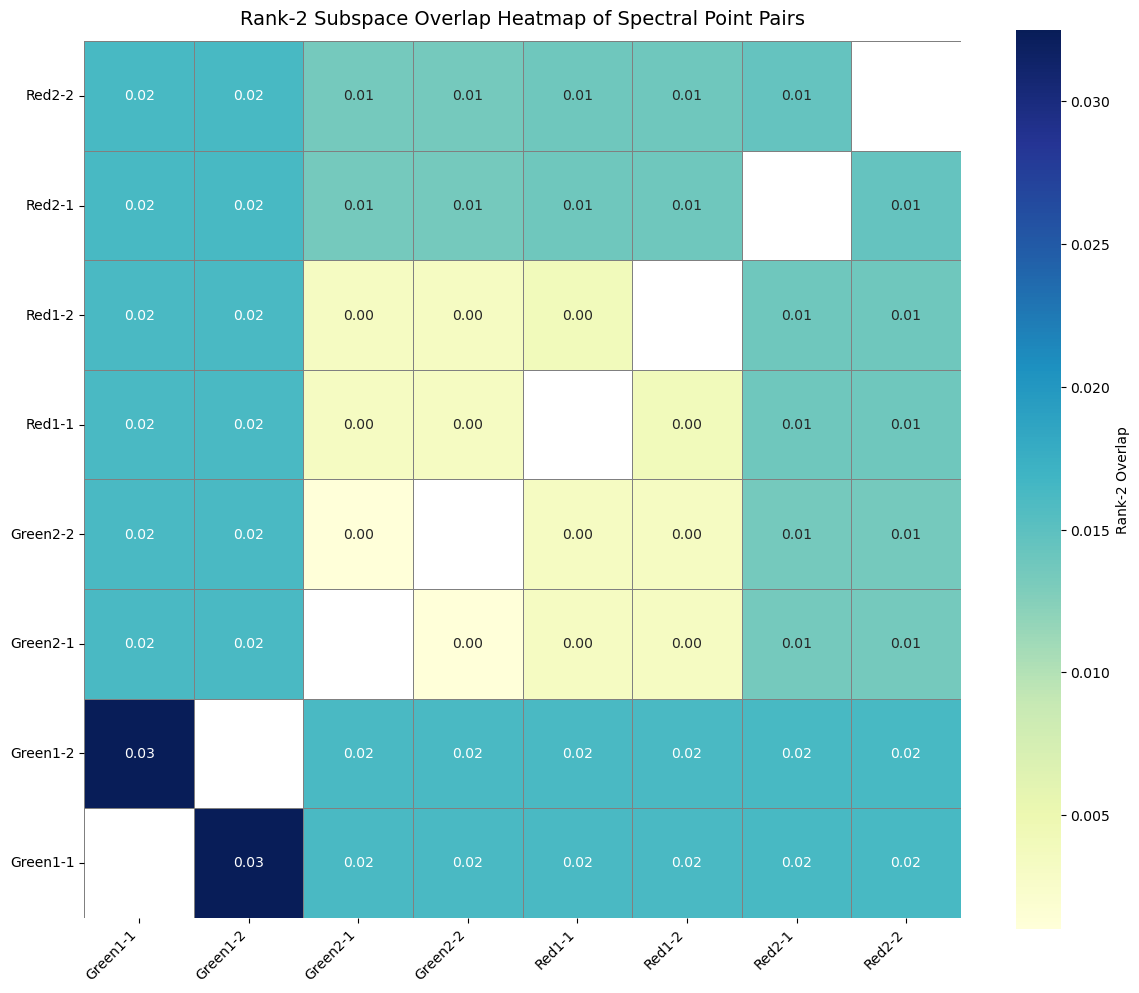

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


# Extract unique point labels
all_labels = sorted(set(sum([label.split(' + ') for label in df_rank2['ComboLabel']], [])))

# Initialize symmetric matrix
heatmap_matrix = pd.DataFrame(np.nan, index=all_labels, columns=all_labels)

# Fill upper/lower triangles with overlap scores
for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
    heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']

# Mask diagonal (self-combinations)
np.fill_diagonal(heatmap_matrix.values, np.nan)

# Select top-5 pairs by score
top5 = df_rank2.nlargest(5, 'Rank2_Overlap_q')

# Plot heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    heatmap_matrix, annot=True, fmt=".2f", cmap="YlGnBu", square=True,
    cbar_kws={'label': 'Rank-2 Overlap'}, linewidths=0.5, linecolor='gray'
)

# Title
plt.title("Rank-2 Subspace Overlap Heatmap of Spectral Point Pairs", fontsize=14, pad=12)

# Axis formatting
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
ax.invert_yaxis()  # conventional orientation for symmetric heatmaps

# Layout
plt.tight_layout()
plt.show()


In [ ]:
# Compute overlap for top-2 outlier eigenvectors
# Recompute eigpairs (eigvecs order matches eigvals)
eigvals_all, eigvecs_all = torch.linalg.eig(L)  # eigvecs: shape (np, np)
eigvecs_np = eigvecs_all.detach().cpu().numpy()  # shape: (np, np)

# Indices of the top-2 eigenvalues by real part
top2_idx = np.argsort(eigvals_real)[-2:]

# Ground-truth subspace W* ∈ ℝ^{d×p}
# Compare after reshaping eigenvectors to (n×p)
overlaps = []

for i, idx in enumerate(top2_idx):
    vec_np = eigvecs_np[:, idx].real            # shape: (n*p,)
    vec_reshaped = vec_np.reshape(n, p)         # shape: (n, p)
    U = torch.tensor(vec_reshaped, dtype=torch.float32, device=device)  # (n, p)

    # Project to feature space and normalize
    V_proj = X.T @ U          # shape: (d, p)
    W_proj = W_star           # shape: (d, p)

    # Column-wise normalization
    V_proj = V_proj / torch.norm(V_proj, dim=0, keepdim=True)
    W_proj = W_proj / torch.norm(W_proj, dim=0, keepdim=True)

    # overlap = (1/p) * ||V^T W||_F^2
    inner_prod = V_proj.T @ W_proj      # shape: (p, p)
    q = torch.sum(inner_prod ** 2).item() / p
    overlaps.append(q)
    print(f"Overlap q (top-{i+1} jump eigenvector) ≈ {q:.4f}")


Overlap q (top-1 jump eigenvector) ≈ 0.0009
Overlap q (top-2 jump eigenvector) ≈ 0.0123


#### 提取谱估计器的主子空间 

In [ ]:
# Step 6: Extract principal subspace from the spectral matrix (right eigenvectors)
eigvals_all, eigvecs_all = torch.linalg.eig(L)  # complex-valued in general
eigvecs_real = eigvecs_all.real                 # shape: (np, np)

# Reshape to [n, p, -1]
eigvecs_np = eigvecs_real.detach().cpu().numpy().reshape(n, p, -1)  # (n, p, np/p = n)

# Select eigenvectors corresponding to the top-p eigenvalues by real part
top_p_idx = np.argsort(eigvals_all.real.detach().cpu().numpy())[-p:]
V_hat = eigvecs_all[:, top_p_idx].real         # shape: (np, p)
V_hat = V_hat.reshape(n, p, p)                 # per-sample p×p block; will flatten to (n*p, p)
V_hat_flat = V_hat.reshape(n * p, p)

# Ground-truth latent Z and its flattened form
Z_true = X @ W_star              # (n, p)
Z_true_flat = Z_true.reshape(n * p, 1)  # (n*p, 1)

# Estimate M ∈ ℝ^{p×1} mapping the estimated subspace to the true subspace
M_hat = (V_hat_flat.T @ Z_true_flat) / (n * p)
M_hat = M_hat.squeeze()  # shape: (p,)


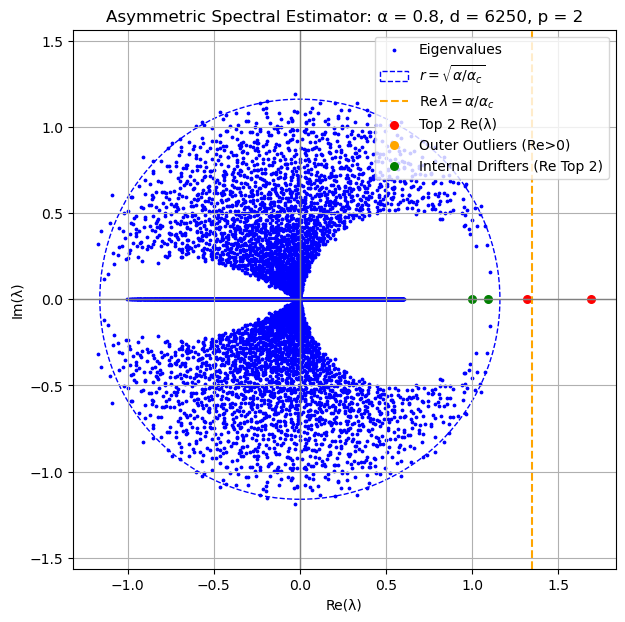

                     Type              λ1              λ2  Alignment Score
0      Red-Red(1.69,1.32)  1.6885+0.0000j  1.3173+0.0000j           0.0784
1    Red-Green(1.69,1.09)  1.6885+0.0000j  1.0933+0.0000j           0.0784
2    Red-Green(1.69,1.00)  1.6885+0.0000j  1.0003+0.0000j           0.0784
5  Green-Green(1.09,1.00)  1.0933+0.0000j  1.0003+0.0000j           0.0405
3    Red-Green(1.32,1.09)  1.3173+0.0000j  1.0933+0.0000j           0.0208
4    Red-Green(1.32,1.00)  1.3173+0.0000j  1.0003+0.0000j           0.0208


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr
import pandas as pd
from itertools import combinations

# Alignment score (principal angles via SVD)
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Subspace from a pair of eigenvectors
def extract_W_from_eigpair(eigvecs_np, eigvals_np, eigval_pair, X, W_star, p=2, label=""):
    idx1 = np.argmin(np.abs(eigvals_np - eigval_pair[0]))
    idx2 = np.argmin(np.abs(eigvals_np - eigval_pair[1]))
    v1 = eigvecs_np[:, idx1]
    v2 = eigvecs_np[:, idx2]

    V1 = v1.reshape(-1, p)
    V2 = v2.reshape(-1, p)
    V = np.hstack([V1, V2])

    U = X.cpu().numpy().T @ V
    W_hat = U[:, :p]
    W_hat = W_hat / norm(W_hat, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_pair[0], eigval_pair[1], score)

# Eigenpairs
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()
d = W_star_np.shape[0]

# Classify eigenvalues
R = np.sqrt(alpha / alpha_c)
thresh_ext = alpha / alpha_c

real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]

red_vals = sorted(eigvals_real_only, key=lambda z: z.real, reverse=True)[:2]
orange_candidates = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
orange_vals = [z for z in orange_candidates if z not in red_vals]
green_candidates = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6) and abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]

# Spectrum (optional)
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals], color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals], color="orange", s=30, label="Outer Outliers (Re>0)")
plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals], color="green", s=30, label="Internal Drifters (Re Top 2)")

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Pairwise combinations (red/orange/green)
highlight_vals = [("Red", z) for z in red_vals] + \
                 [("Orange", z) for z in orange_vals] + \
                 [("Green", z) for z in green_vals]

results = []
for (label1, z1), (label2, z2) in combinations(highlight_vals, 2):
    pair_label = f"{label1}-{label2}({z1.real:.2f},{z2.real:.2f})"
    result = extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2), X, W_star, p=2, label=pair_label)
    results.append(result)

# Output
df = pd.DataFrame(results, columns=["Type", "λ1", "λ2", "Alignment Score"])
pd.set_option("display.precision", 4)
print(df.sort_values(by="Alignment Score", ascending=False))


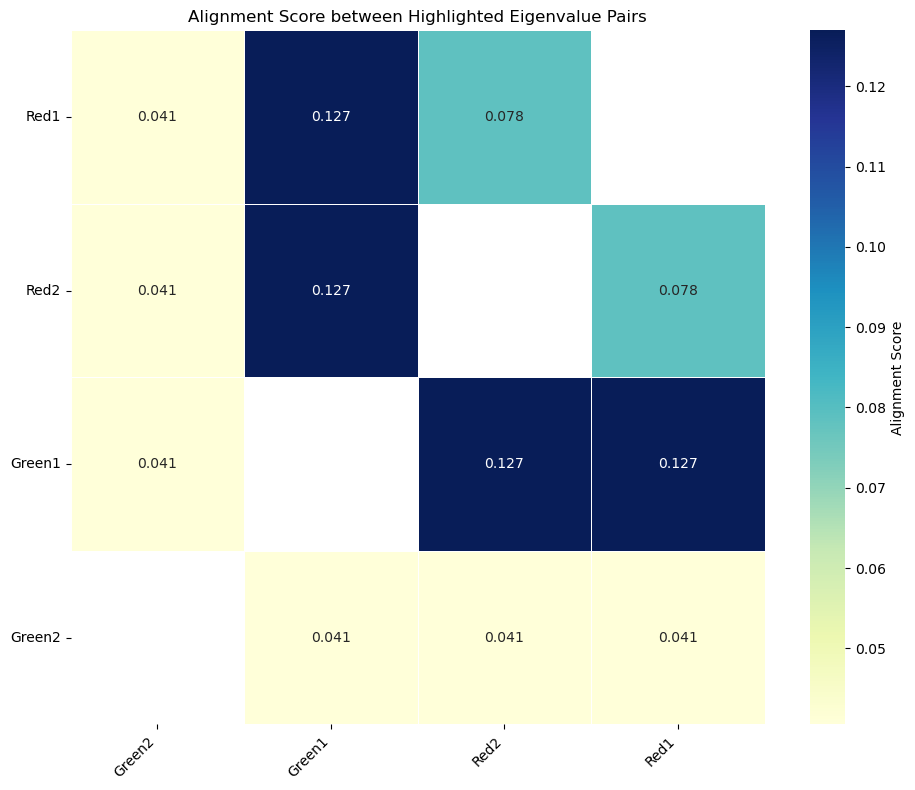

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import combinations

# Example eigenvalue lists (replace with your values)
# green_vals = [0.52, 0.47]
# orange_vals = [0.73, 0.65]
# red_vals = [0.91, 0.85]

# Labels: descending index within group (e.g., Green2, Green1)
green_labels = [(f"Green{len(green_vals)-i}", z) for i, z in enumerate(green_vals)]
orange_labels = [(f"Orange{len(orange_vals)-i}", z) for i, z in enumerate(orange_vals)]
red_labels = [(f"Red{len(red_vals)-i}", z) for i, z in enumerate(red_vals)]

# Concatenate in order: Green → Orange → Red
all_labels = green_labels + orange_labels + red_labels

# Label → value map and fixed display order
label_map = dict(all_labels)
label_order = [label for label, _ in all_labels]

# Initialize symmetric matrix
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)

# Fill alignment scores (symmetric)
for (label1, z1), (label2, z2) in combinations(label_map.items(), 2):
    _, _, _, score = extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2), X, W_star, p=2)
    heatmap_df.loc[label1, label2] = score
    heatmap_df.loc[label2, label1] = score

# Plot
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    heatmap_df, annot=True, cmap="YlGnBu", fmt=".3f", square=True,
    linewidths=0.5, cbar_kws={"label": "Alignment Score"}
)
ax.set_title("Alignment Score between Highlighted Eigenvalue Pairs")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()  # place the first label at top-left

plt.tight_layout()
plt.show()


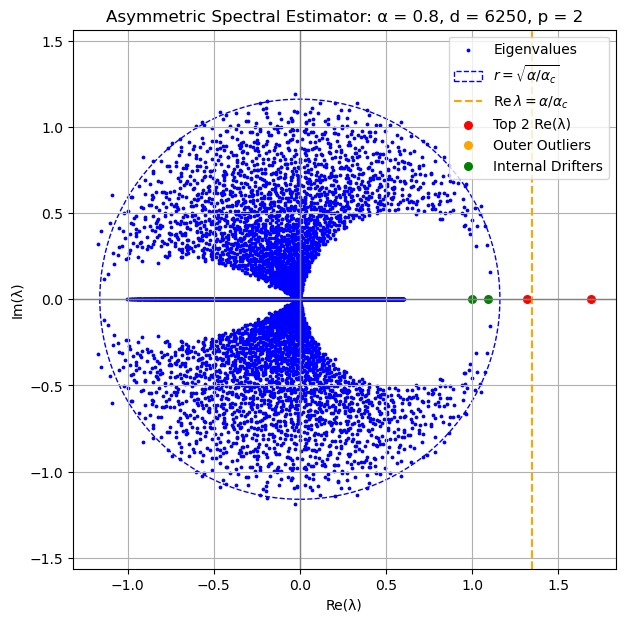


=== Alignment Score for Individual Eigenvalues ===
     Type               λ  Alignment Score
0  Green2  1.0933+0.0000j           0.0405
1  Green1  1.0003+0.0000j           0.1270
2    Red2  1.6885+0.0000j           0.0784
3    Red1  1.3173+0.0000j           0.0208

=== Alignment Score for Pairs of Eigenvalues ===
            Pair              λ1              λ2  Alignment Score
3    Green1-Red2  1.0003+0.0000j  1.6885+0.0000j           0.1270
4    Green1-Red1  1.0003+0.0000j  1.3173+0.0000j           0.1270
5      Red2-Red1  1.6885+0.0000j  1.3173+0.0000j           0.0784
0  Green2-Green1  1.0933+0.0000j  1.0003+0.0000j           0.0405
1    Green2-Red2  1.0933+0.0000j  1.6885+0.0000j           0.0405
2    Green2-Red1  1.0933+0.0000j  1.3173+0.0000j           0.0405


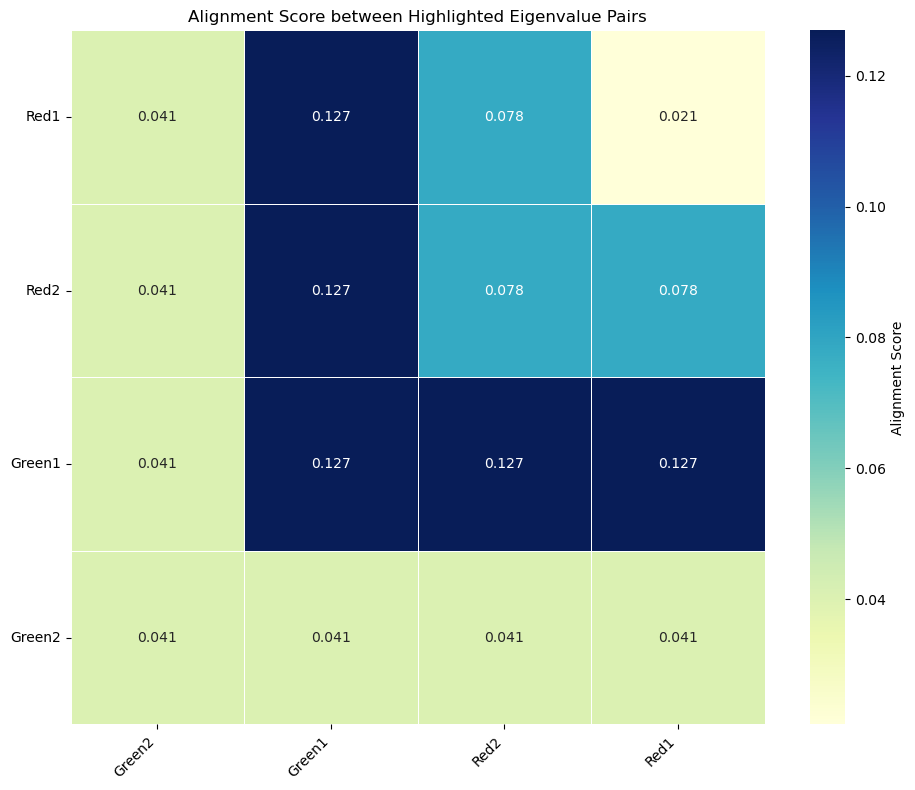

In [58]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.linalg import norm
from scipy.linalg import qr
from itertools import combinations



# ========== 对齐度函数 ==========
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# ========== 子空间提取（单个特征值） ==========
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]
    V = v_hat.reshape(-1, p)
    U = (X.cpu().numpy().T) @ V
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# ========== 子空间提取（特征值对组合） ==========
def extract_W_from_eigpair(eigvecs_np, eigvals_np, eigval_pair, X, W_star, p=2, label=""):
    idx1 = np.argmin(np.abs(eigvals_np - eigval_pair[0]))
    idx2 = np.argmin(np.abs(eigvals_np - eigval_pair[1]))
    v1 = eigvecs_np[:, idx1]
    v2 = eigvecs_np[:, idx2]
    V1 = v1.reshape(-1, p)
    V2 = v2.reshape(-1, p)
    V = np.hstack([V1, V2])
    U = X.cpu().numpy().T @ V
    W_hat = U[:, :p]
    W_hat = W_hat / norm(W_hat, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_pair[0], eigval_pair[1], score)

# ========== 提取谱信息 ==========
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()

# ========== 分类特征值（红橙绿） ==========
R = np.sqrt(alpha / alpha_c)
thresh_ext = alpha / alpha_c
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]

red_vals = sorted(eigvals_real_only, key=lambda z: z.real, reverse=True)[:2]
orange_candidates = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
orange_vals = [z for z in orange_candidates if z not in red_vals]
green_candidates = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6) and abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]

# ========== 编号与标签构造（倒序编号） ==========
green_vals_sorted = sorted(green_vals, key=lambda z: z.real, reverse=True)
green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals_sorted)]

orange_vals_sorted = sorted(orange_vals, key=lambda z: z.real, reverse=True)
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals_sorted)]

red_vals_sorted = sorted(red_vals, key=lambda z: z.real, reverse=True)
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals_sorted)]


# ========== 【一次性谱图绘制】 ==========
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")
plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals], color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals], color="orange", s=30, label="Outer Outliers")
plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals], color="green", s=30, label="Internal Drifters")
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# ========== Code 1：单点对齐得分 ==========
results_single = []
for label, z in all_labels:
    results_single.append(extract_W_from_eigenvectors(eigvecs_np, z, X, W_star, p=2, label=label))
df_single = pd.DataFrame(results_single, columns=["Type", "λ", "Alignment Score"])
print("\n=== Alignment Score for Individual Eigenvalues ===")
print(df_single)

# ========== Code 2：两两组合对齐得分 ==========
results_pair = []
for (label1, z1), (label2, z2) in combinations(all_labels, 2):
    pair_label = f"{label1}-{label2}"
    results_pair.append(extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2), X, W_star, p=2, label=pair_label))
df_pair = pd.DataFrame(results_pair, columns=["Pair", "λ1", "λ2", "Alignment Score"])
print("\n=== Alignment Score for Pairs of Eigenvalues ===")
print(df_pair.sort_values(by="Alignment Score", ascending=False))

# ========== Code 3：热力图绘制 ==========
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)

# 对角线：填入单点 alignment score
for label, _, score in results_single:
    heatmap_df.loc[label, label] = score

# 非对角线：填入组合 alignment score
for pair_label, _, _, score in results_pair:
    name1, name2 = pair_label.split("-")
    heatmap_df.loc[name1, name2] = score
    heatmap_df.loc[name2, name1] = score

# 绘图
plt.figure(figsize=(10, 8))
ax = sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".3f", square=True,
                 linewidths=0.5, cbar_kws={"label": "Alignment Score"})
ax.set_title("Alignment Score between Highlighted Eigenvalue Pairs")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()  # 让 Green2 在左上角
plt.tight_layout()
plt.show()


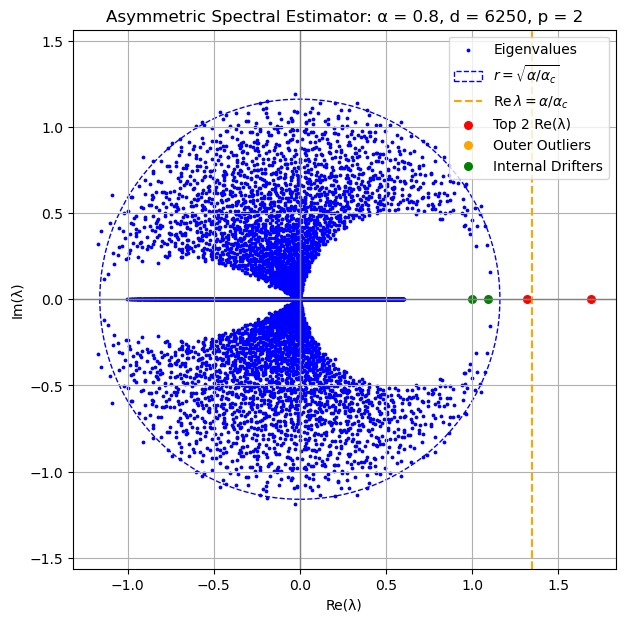


=== Alignment Score for Individual Eigenvalues ===
     Type               λ  Alignment Score
0  Green1  1.0933+0.0000j           0.0405
1  Green2  1.0003+0.0000j           0.1270
2    Red1  1.6885+0.0000j           0.0784
3    Red2  1.3173+0.0000j           0.0208

=== Alignment Score for Pairs of Eigenvalues ===
            Pair              λ1              λ2  Alignment Score
3    Green2-Red1  1.0003+0.0000j  1.6885+0.0000j           0.1270
4    Green2-Red2  1.0003+0.0000j  1.3173+0.0000j           0.1270
5      Red1-Red2  1.6885+0.0000j  1.3173+0.0000j           0.0784
0  Green1-Green2  1.0933+0.0000j  1.0003+0.0000j           0.0405
1    Green1-Red1  1.0933+0.0000j  1.6885+0.0000j           0.0405
2    Green1-Red2  1.0933+0.0000j  1.3173+0.0000j           0.0405


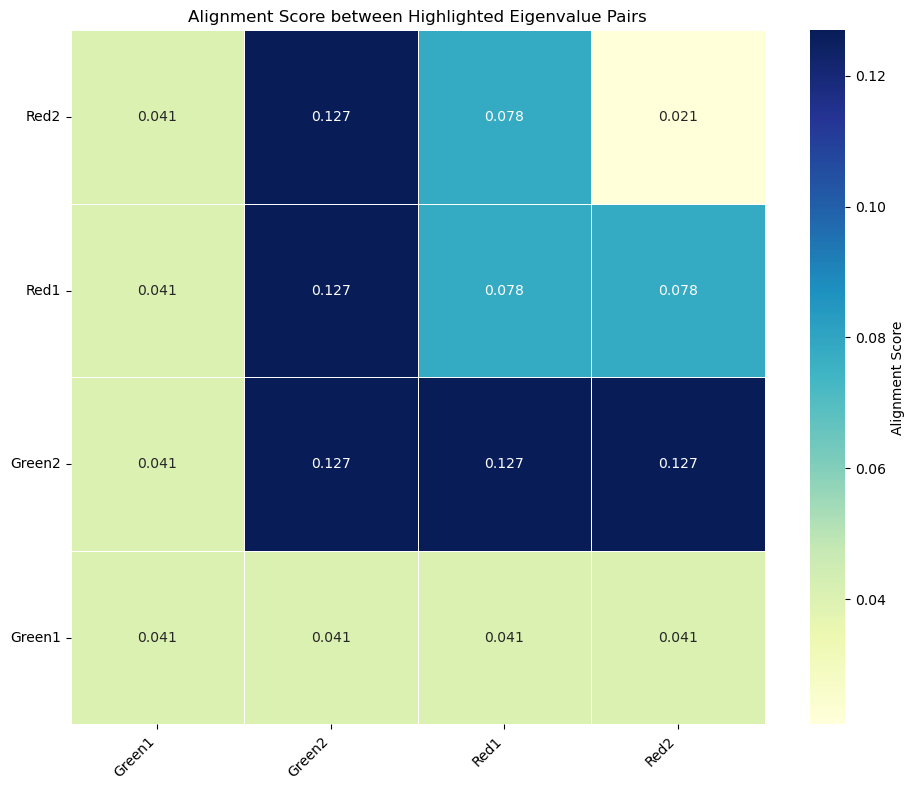

In [61]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.linalg import norm
from scipy.linalg import qr
from itertools import combinations

# ========== 对齐度函数 ==========
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# ========== 子空间提取（单个特征值） ==========
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]
    V = v_hat.reshape(-1, p)
    U = (X.cpu().numpy().T) @ V
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# ========== 子空间提取（特征值对组合） ==========
def extract_W_from_eigpair(eigvecs_np, eigvals_np, eigval_pair, X, W_star, p=2, label=""):
    idx1 = np.argmin(np.abs(eigvals_np - eigval_pair[0]))
    idx2 = np.argmin(np.abs(eigvals_np - eigval_pair[1]))
    v1 = eigvecs_np[:, idx1]
    v2 = eigvecs_np[:, idx2]
    V1 = v1.reshape(-1, p)
    V2 = v2.reshape(-1, p)
    V = np.hstack([V1, V2])
    U = X.cpu().numpy().T @ V
    W_hat = U[:, :p]
    W_hat = W_hat / norm(W_hat, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_pair[0], eigval_pair[1], score)

# ========== 提取谱信息 ==========
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()

# ========== 分类特征值（红橙绿） ==========
R = np.sqrt(alpha / alpha_c)
thresh_ext = alpha / alpha_c
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]

red_vals = sorted(eigvals_real_only, key=lambda z: z.real, reverse=True)[:2]
orange_candidates = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
orange_vals = [z for z in orange_candidates if z not in red_vals]
green_candidates = [z for z in eigvals_real_only if abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]

# ========== 正确编号（每组内实部大的是1） ==========
green_vals_sorted = sorted(green_vals, key=lambda z: z.real, reverse=True)
green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals_sorted)]

orange_vals_sorted = sorted(orange_vals, key=lambda z: z.real, reverse=True)
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals_sorted)]

red_vals_sorted = sorted(red_vals, key=lambda z: z.real, reverse=True)
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals_sorted)]

# ========== 合并标签 ==========
all_labels = green_labels + orange_labels + red_labels
label_order = [label for label, _ in all_labels]  # Green1 Green2 Orange1 Orange2 Red1 Red2

# ========== 【一次性谱图绘制】 ==========
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")
plt.scatter([z.real for _, z in red_labels], [z.imag for _, z in red_labels], color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels], [z.imag for _, z in orange_labels], color="orange", s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels], color="green", s=30, label="Internal Drifters")
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# ========== Code 1：单点对齐得分 ==========
results_single = []
for label, z in all_labels:
    results_single.append(extract_W_from_eigenvectors(eigvecs_np, z, X, W_star, p=2, label=label))
df_single = pd.DataFrame(results_single, columns=["Type", "λ", "Alignment Score"])
print("\n=== Alignment Score for Individual Eigenvalues ===")
print(df_single)

# ========== Code 2：两两组合对齐得分 ==========
results_pair = []
for (label1, z1), (label2, z2) in combinations(all_labels, 2):
    pair_label = f"{label1}-{label2}"
    results_pair.append(extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2), X, W_star, p=2, label=pair_label))
df_pair = pd.DataFrame(results_pair, columns=["Pair", "λ1", "λ2", "Alignment Score"])
print("\n=== Alignment Score for Pairs of Eigenvalues ===")
print(df_pair.sort_values(by="Alignment Score", ascending=False))

# ========== Code 3：热力图绘制 ==========
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)

# 对角线：填入单点 alignment score
for label, _, score in results_single:
    heatmap_df.loc[label, label] = score

# 非对角线：填入组合 alignment score
for pair_label, _, _, score in results_pair:
    name1, name2 = pair_label.split("-")
    heatmap_df.loc[name1, name2] = score
    heatmap_df.loc[name2, name1] = score

# 绘图
plt.figure(figsize=(10, 8))
ax = sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".3f", square=True,
                 linewidths=0.5, cbar_kws={"label": "Alignment Score"})
ax.set_title("Alignment Score between Highlighted Eigenvalue Pairs")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()  # 让 Green1 出现在左上角
plt.tight_layout()
plt.show()


/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_3080/1408444067.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


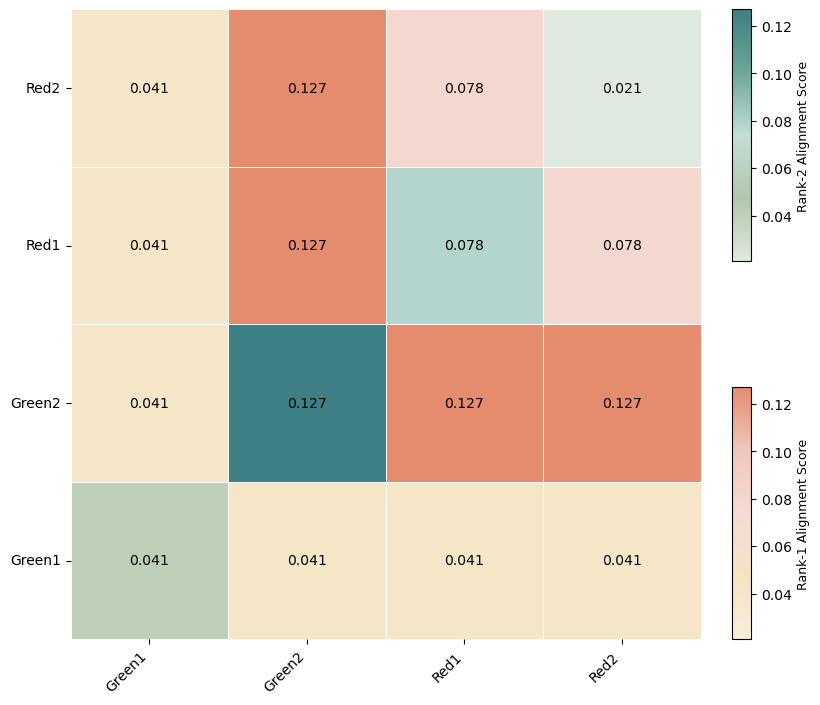

In [90]:
# ========== 创建热力图数据 ==========
# 初始化 DataFrame
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)

# 填入单点（对角线）得分
for _, row in df_single.iterrows():
    label = row["Type"]
    score = row["Alignment Score"]
    heatmap_df.loc[label, label] = score

# 填入两两组合（非对角线）得分
for _, row in df_pair.iterrows():
    label1, label2 = row["Pair"].split("-")
    score = row["Alignment Score"]
    heatmap_df.loc[label1, label2] = score
    heatmap_df.loc[label2, label1] = score  # 对称填充

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



# 颜色列表
diag_colors = ["#FAEED9", "#F5E3C2", "#F5DBD4", "#F0C7BC", "#E58B6E"]
offdiag_colors = ["#DFE9DF", "#B2C6AB", "#C2DED7", "#6DA798", "#3E7F84"]
diag_cmap = LinearSegmentedColormap.from_list("diag_cmap", diag_colors)
offdiag_cmap = LinearSegmentedColormap.from_list("offdiag_cmap", offdiag_colors)



# 创建 mask
mask_diag = pd.DataFrame(True, index=label_order, columns=label_order)
np.fill_diagonal(mask_diag.values, False)
mask_offdiag = ~mask_diag

# 值范围
vmin = np.nanmin(heatmap_df.values)
vmax = np.nanmax(heatmap_df.values)

# 创建图形
fig, ax = plt.subplots(figsize=(8, 7))

# plot1: off-diagonal（Rank-2）
sns.heatmap(heatmap_df, mask=mask_diag, cmap=offdiag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)

# 添加紧凑 colorbar
cbar_ax1 = inset_axes(ax, width="3%", height="40%", loc='upper right', bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm1 = plt.cm.ScalarMappable(cmap=offdiag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar1 = fig.colorbar(sm1, cax=cbar_ax1)
cbar1.set_label("Rank-2 Alignment Score", fontsize=9)

# plot2: diagonal（Rank-1）
sns.heatmap(heatmap_df, mask=mask_offdiag, cmap=diag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)

# 添加第二个 colorbar
cbar_ax2 = inset_axes(ax, width="3%", height="40%", loc='lower right', bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm2 = plt.cm.ScalarMappable(cmap=diag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar2 = fig.colorbar(sm2, cax=cbar_ax2)
cbar2.set_label("Rank-1 Alignment Score", fontsize=9)

# 注释数值
for i in range(len(label_order)):
    for j in range(len(label_order)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}", ha='center', va='center', fontsize=10)

# 美化

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()

plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)

plt.show()


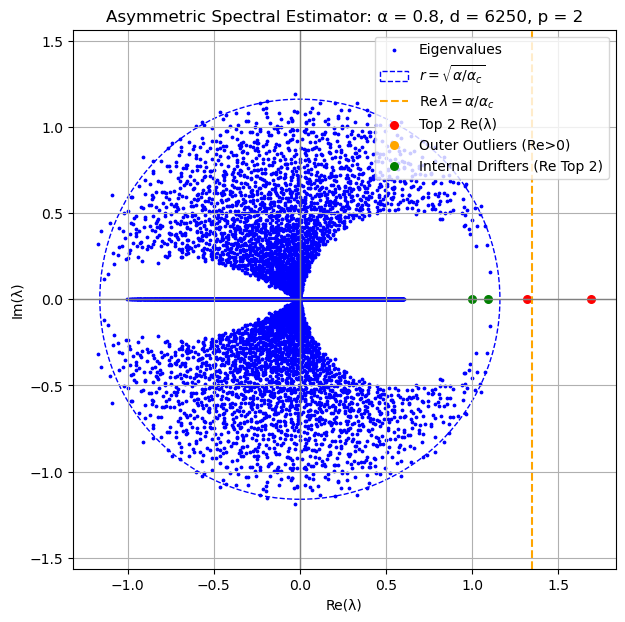

                Type              λ1              λ2  Alignment Score
0    Red-(1.69,1.32)  1.6885+0.0000j  1.3173+0.0000j           0.0784
1  Green-(1.09,1.00)  1.0933+0.0000j  1.0003+0.0000j           0.0405


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.linalg import norm
from scipy.linalg import qr
from itertools import combinations

# Alignment score (principal angles via SVD)
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Subspace from a single eigenvalue
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]
    V = v_hat.reshape(-1, p)
    U = (X.cpu().numpy().T) @ V
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# Subspace from a pair of eigenvalues
def extract_W_from_eigpair(eigvecs_np, eigvals_np, eigval_pair, X, W_star, p=2, label=""):
    idx1 = np.argmin(np.abs(eigvals_np - eigval_pair[0]))
    idx2 = np.argmin(np.abs(eigvals_np - eigval_pair[1]))
    v1 = eigvecs_np[:, idx1]
    v2 = eigvecs_np[:, idx2]
    V1 = v1.reshape(-1, p)
    V2 = v2.reshape(-1, p)
    V = np.hstack([V1, V2])
    U = X.cpu().numpy().T @ V
    W_hat = U[:, :p]
    W_hat = W_hat / norm(W_hat, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_pair[0], eigval_pair[1], score)

# Eigenpairs
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()

# Eigenvalue groups (red/orange/green)
R = np.sqrt(alpha / alpha_c)
thresh_ext = alpha / alpha_c
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]

red_vals = sorted(eigvals_real_only, key=lambda z: z.real, reverse=True)[:2]
orange_candidates = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
orange_vals = [z for z in orange_candidates if z not in red_vals]
green_candidates = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6) and abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]

# Labels (descending within each group)
green_vals_sorted = sorted(green_vals, key=lambda z: z.real, reverse=True)
green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals_sorted)]

orange_vals_sorted = sorted(orange_vals, key=lambda z: z.real, reverse=True)
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals_sorted)]

red_vals_sorted = sorted(red_vals, key=lambda z: z.real, reverse=True)
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals_sorted)]

# One-shot spectrum plot (optional)
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")
plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals], color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals], color="orange", s=30, label="Outer Outliers")
plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals], color="green", s=30, label="Internal Drifters")
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Code 1: single-eigenvalue alignment
results_single = []
for label, z in all_labels:
    results_single.append(extract_W_from_eigenvectors(eigvecs_np, z, X, W_star, p=2, label=label))
df_single = pd.DataFrame(results_single, columns=["Type", "λ", "Alignment Score"])
print("\n=== Alignment Score for Individual Eigenvalues ===")
print(df_single)

# Code 2: pairwise alignment
results_pair = []
for (label1, z1), (label2, z2) in combinations(all_labels, 2):
    pair_label = f"{label1}-{label2}"
    results_pair.append(extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2), X, W_star, p=2, label=pair_label))
df_pair = pd.DataFrame(results_pair, columns=["Pair", "λ1", "λ2", "Alignment Score"])
print("\n=== Alignment Score for Pairs of Eigenvalues ===")
print(df_pair.sort_values(by="Alignment Score", ascending=False))

# Code 3: heatmap
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)

# Diagonal: single-eigenvalue scores
for label, _, score in results_single:
    heatmap_df.loc[label, label] = score

# Off-diagonal: pair scores
for pair_label, _, _, score in results_pair:
    name1, name2 = pair_label.split("-")
    heatmap_df.loc[name1, name2] = score
    heatmap_df.loc[name2, name1] = score

# Plot heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".3f", square=True,
                 linewidths=0.5, cbar_kws={"label": "Alignment Score"})
ax.set_title("Alignment Score between Highlighted Eigenvalue Pairs")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()  # place first label at top-left
plt.tight_layout()
plt.show()


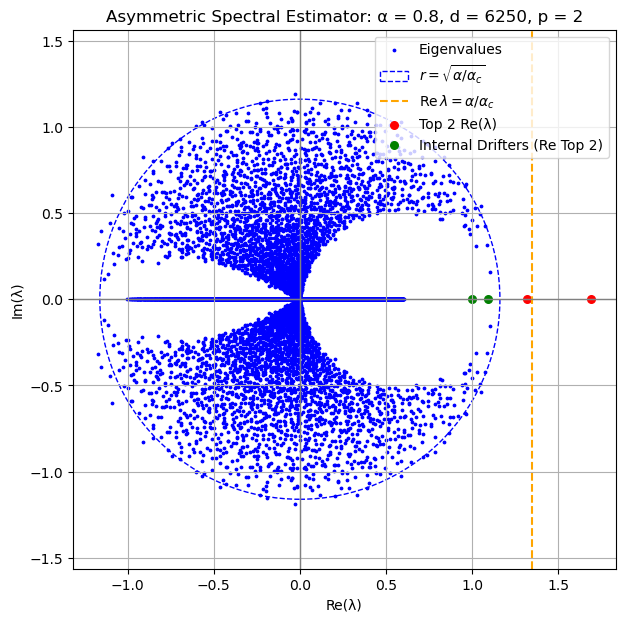

      Type      λ (eigval)  Alignment Score
0    Red-1  1.6885+0.0000j           0.0784
1    Red-2  1.3173+0.0000j           0.0208
2  Green-1  1.0933+0.0000j           0.0405
3  Green-2  1.0003+0.0000j           0.1270


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr
import pandas as pd

# Alignment score (principal angles via SVD)
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Subspace extraction & alignment (single eigenvalue)
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]
    V = v_hat.reshape(-1, p)
    U = (X.cpu().numpy().T) @ V
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# Eigenpairs
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()
d = W_star_np.shape[0]

# Thresholds
R = np.sqrt(alpha / alpha_c)          # spectral radius
thresh_ext = alpha / alpha_c          # vertical threshold (Re line)

# Real-valued eigenvalues
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]

# Red: top-2 by Re(λ)
red_vals = sorted(eigvals_real_only, key=lambda z: z.real, reverse=True)[:2]

# Orange: |λ|>R, Re>0, excluding red
orange_candidates = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
orange_vals = [z for z in orange_candidates if z not in red_vals]

# Green: real-axis, inside circle, top-2 by Re(λ)
green_candidates = [z for z in eigvals_np 
                    if np.isclose(z.imag, 0.0, atol=1e-6) and abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]

# Visualization
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

# Red points
plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals],
            color="red", s=30, label="Top 2 Re(λ)")

# Orange points
if orange_vals:
    plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals],
                color="orange", s=30, label="Outer Outliers (Re>0)")

# Green points
if green_vals:
    plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals],
                color="green", s=30, label="Internal Drifters (Re Top 2)")

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Alignment evaluation
results = []
for i, val in enumerate(red_vals):
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=f"Red-{i+1}"))
for i, val in enumerate(orange_vals):
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=f"Orange-{i+1}"))
for i, val in enumerate(green_vals):
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=f"Green-{i+1}"))

# Tabular output
df = pd.DataFrame(results, columns=["Type", "λ (eigval)", "Alignment Score"])
pd.set_option("display.precision", 4)
print(df)
